<b> Vamos a trabajar un poco con series de Fourier! Empecemos importando algunas librerías <b/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, signal, integrate
import sys
from IPython.display import Image
sys.path.insert(1, 'Some functions/')
from generate_signals import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Seteemos el el período de las señales periódicas y otras cantidades para "simular" señales de tiempo continuo.

In [2]:
# Period
T = 1
# Sampling rate in Hz
fs = 1000
#Sampling period
Ts = 1/fs
# Number of periods to be visualized
N=3
duration = T*N

Vamos a generar el eje del tiempo en donde vamos a ver los resultados. Esto lo vamos a usar más adelante!

In [3]:
t = np.linspace(0, duration, round(fs * duration), endpoint=False)  

En este punto vamos a explorar primero la opción "trivial" que es calcular la serie de Fourier usando la definición de sus coeficientes:
$$ a_k=\frac{1}{T}\int_0^{T}x(t)e^{-jk\omega_0 t}dt,\ \ k\in\mathbb{Z}$$
Para ello necesitamos realizar integrales. Esto lo podremos hacer mediante el comando  [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) de [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html). Este comando tiene múltiples posibles argumentos y gran conjunto de parámetros configurables. No es nuestro interés estudiarlo en
profundidad sino sólo usarlo en la versión más sencilla posible para nuestro objetivo. Antes veamos un ejemplo sencillo y luego lo aplicaremos a nuestro problema.

Consideremos la función $f(x)=x^2$. Queremos calcular:
$$ \int_{0}^T x^2\ dx $$

Definimos primero la función a integrar:
 

In [4]:
f = lambda x: x**2

Usamos comando quad en su versión más simple

In [5]:
y, err = integrate.quad(f, 0, T)

In [6]:
print('Valor de la integral=', y) 
print('Valor del error=' , err)


Valor de la integral= 0.33333333333333337
Valor del error= 3.700743415417189e-15


Vamos entonces a calcular los coeficientes de Fourier con este rutina. Vamos a definirnos algunas funciones útiles para tener más versatilidad en el uso 
de esta herramienta

In [7]:
def complex_integral(func, a, b):
    def parte_real(x):
        return np.real(func(x))
    def parte_imag(x):
        return np.imag(func(x))
    integral_parte_real, error_integral_parte_real = integrate.quad(parte_real, a, b)
    integral_parte_imag, error_integral_parte_imag = integrate.quad(parte_imag, a, b)
    integral = (integral_parte_real + 1j*integral_parte_imag, error_integral_parte_real, error_integral_parte_imag)
    return integral

Dado que los integrandos son complejos para el cálculo de los coeficientes del Fourier necesitamos algo que nos permite integral 
parte real y parte imaginaria de una dada función. Esto es lo que hace lo de arriba. Ahora generamos una función que dada una función, un período implicito para la función
y un valor $N$ deseado nos calcula los coeficientes de Fourier hasta ese orden

In [8]:
def fourier_coef(func, N, T):
    coeficientes = []
    for n in range(-N, N+1):
        c = (1./T) * complex_integral(lambda t: func(t) * np.exp(-1j * 2 * np.pi * n * t / T), 0, T)[0]
        coeficientes.append(c)
    return np.array(coeficientes)

Y ya está! Ya podemos calcular coeficientes del Fourier!! Hagamos algunas pruebas! Consideremos las functiones:

$$ x_1(t)= 1, \  t\in[0,T) $$
$$ x_2(t)= e^{j2\pi t/T }, \  t\in[0,T) $$
$$ x_3(t)= \cos(2\pi t/T)$$
$$ x_4(t)= t, \ t\in[0,T) $$


In [9]:
f1 = lambda t: 0.*(t % T) + 1
f2 = lambda t: np.exp(1j * 2 * np.pi * (t % T) / T)
f3 = lambda t: np.cos(2 * np.pi *1* (t % T) / T) 
f4 = lambda t: t % T

<b> Notar arriba que en los argumentos escribí t % T. El operador % es el operador módulo que entrega el resto de una división entera. Esto me permite que las funciones definidas sean periódicas con período T. Esto no es importante para calcular los coeficientes 
de Fourier por definición, ya que las integrales que hay que hacer son siempre en un período. Pero para construir y luego graficar estas funciones como periódicas esta definición es muy práctica ya que Python mismo ya las toma como periódicas cuando las evaluo en sus argumentos!</b>

In [10]:
order_fourier = 50
a1 = fourier_coef(f1, order_fourier, T)
a2 = fourier_coef(f2, order_fourier, T)
a3 = fourier_coef(f3, order_fourier, T)
a4 = fourier_coef(f4, order_fourier, T)

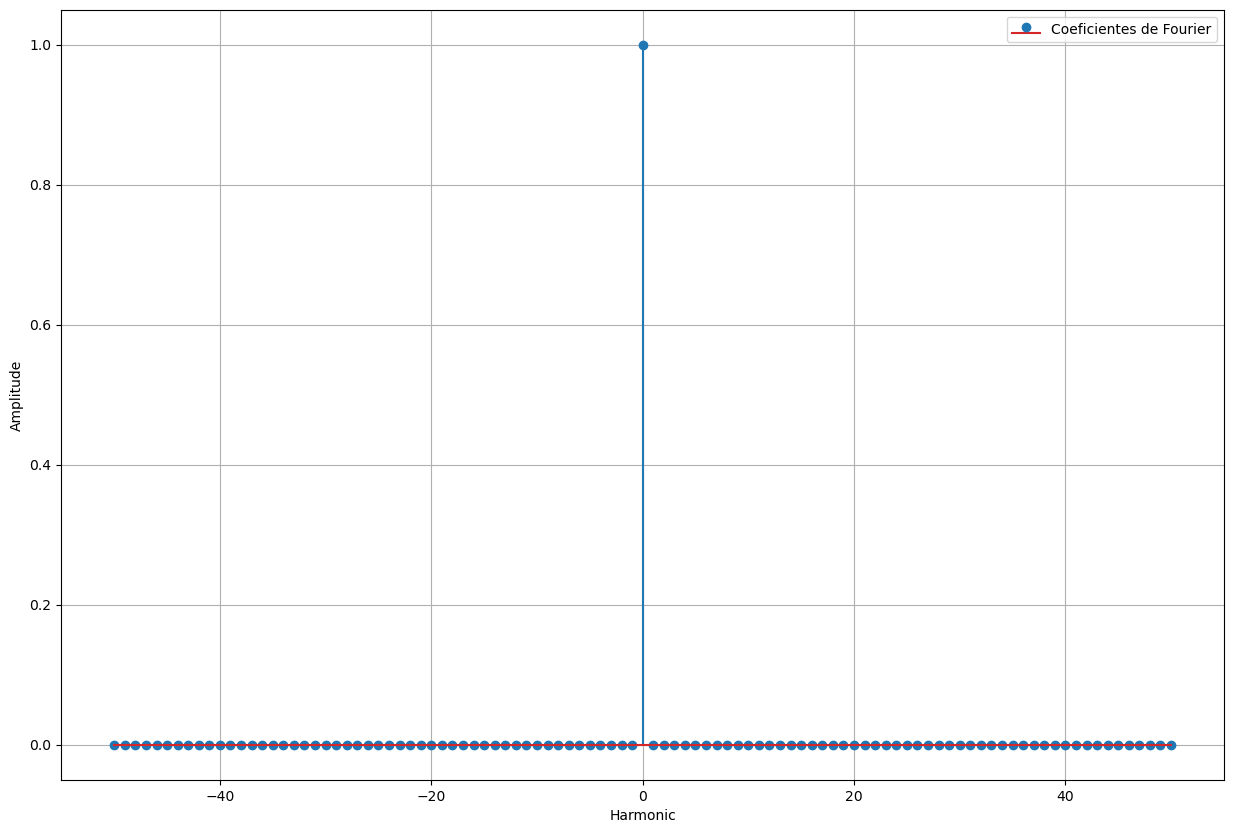

In [11]:
plt.figure(figsize=(15, 10))
plt.xlabel('Harmonic')
plt.ylabel('Amplitude')
plt.stem(np.arange(-order_fourier,order_fourier+1), np.abs(a1), label='Coeficientes de Fourier')   
plt.legend(loc='best')
plt.grid()
plt.show()

Ahora vamos a implementar una función que use los coeficientes de Fourier y nos entrega las series truncadas

In [12]:
def serie_trunc(t,a,T):
    M = int((len(a)-1)/2)
    serie_trun = 0. + 0.j
    for m in range(-M,M+1):
        serie_trun +=  a[m+M] * np.exp(1j * 2. * np.pi * m * t / T)
    return serie_trun

Vamos a hacer analizar la expansión de algunas señales en función de N

Analicemos la señal diente de sierra $$ x_4(t)= t, \ t\in[0,T) $$

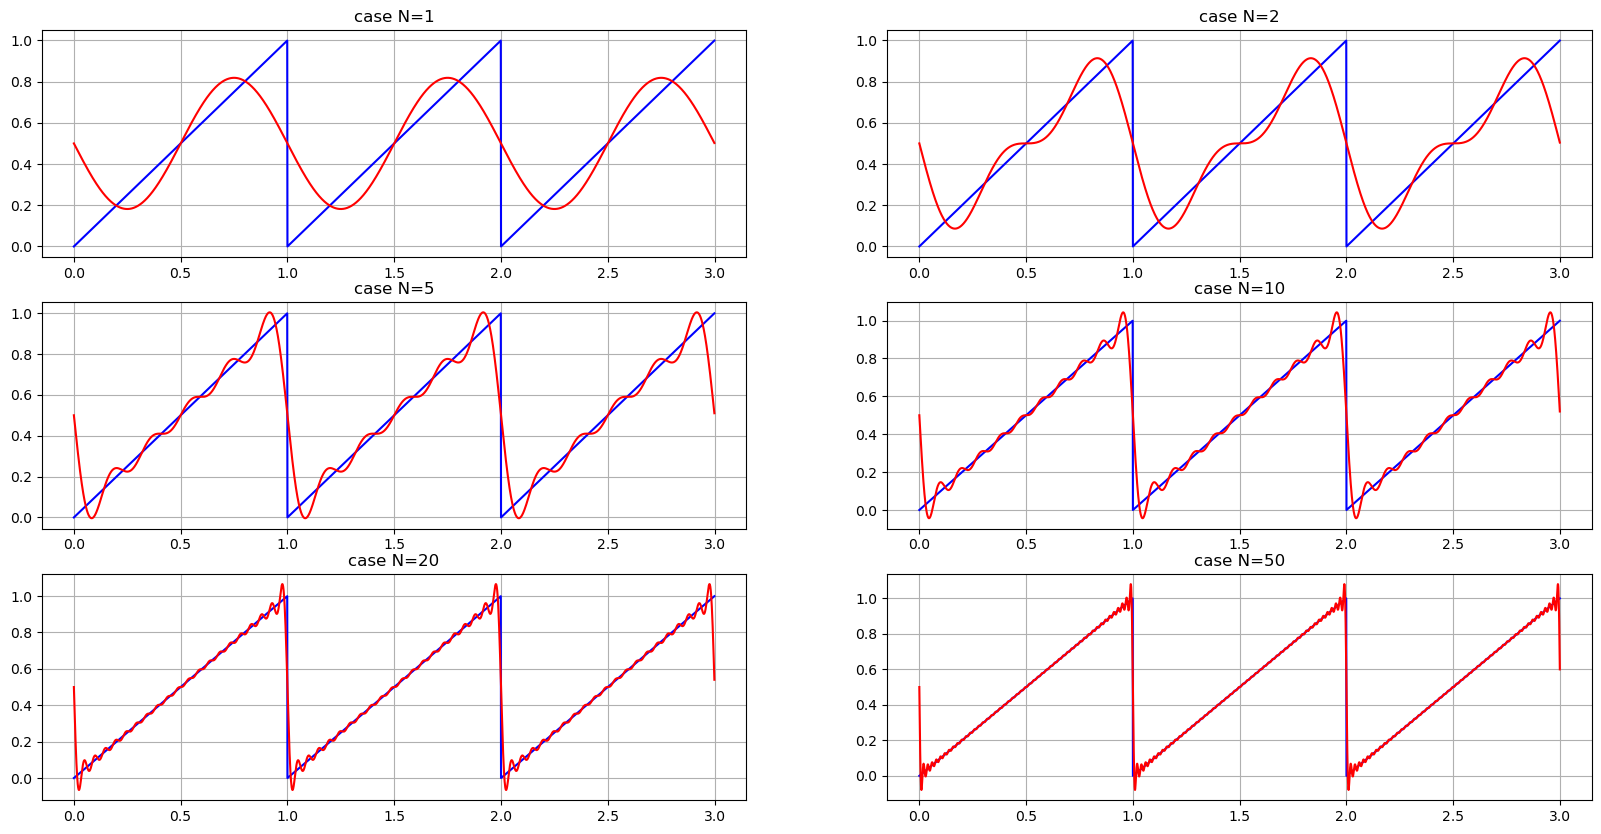

In [13]:
Ns=[1, 2, 5, 10 , 20 , 50]
columnas = 2
filas = int(np.ceil(len(Ns)/columnas))
fig,axs = plt.subplots(filas, columnas, figsize=(20, 10))
for m in range(1, len(Ns)+1):
    a = fourier_coef(f4, Ns[m-1], T)
    f4_reconstruct = serie_trunc(t,a,T)
    fila = (m-1) // columnas
    columna = (m-1) % columnas
    axs[fila, columna].set_title('case N=' + str(Ns[m-1]))
    axs[fila, columna].plot(t, f4(t), color='blue')
    axs[fila, columna].plot(t, np.real(f4_reconstruct), color='red')
    axs[fila, columna].grid()
plt.show()    

Consideremos ahora la onda cuadrada

$$ x(t)=\left\{\begin{array}{cc}
1 & t\in[0,\tau] \\
0 & \mbox{en otro caso}
\end{array}\right. $$


In [14]:
tau = T/2
duty_cycle = tau/T
f5 = lambda t: signal.square(2*np.pi*t/T, duty_cycle)

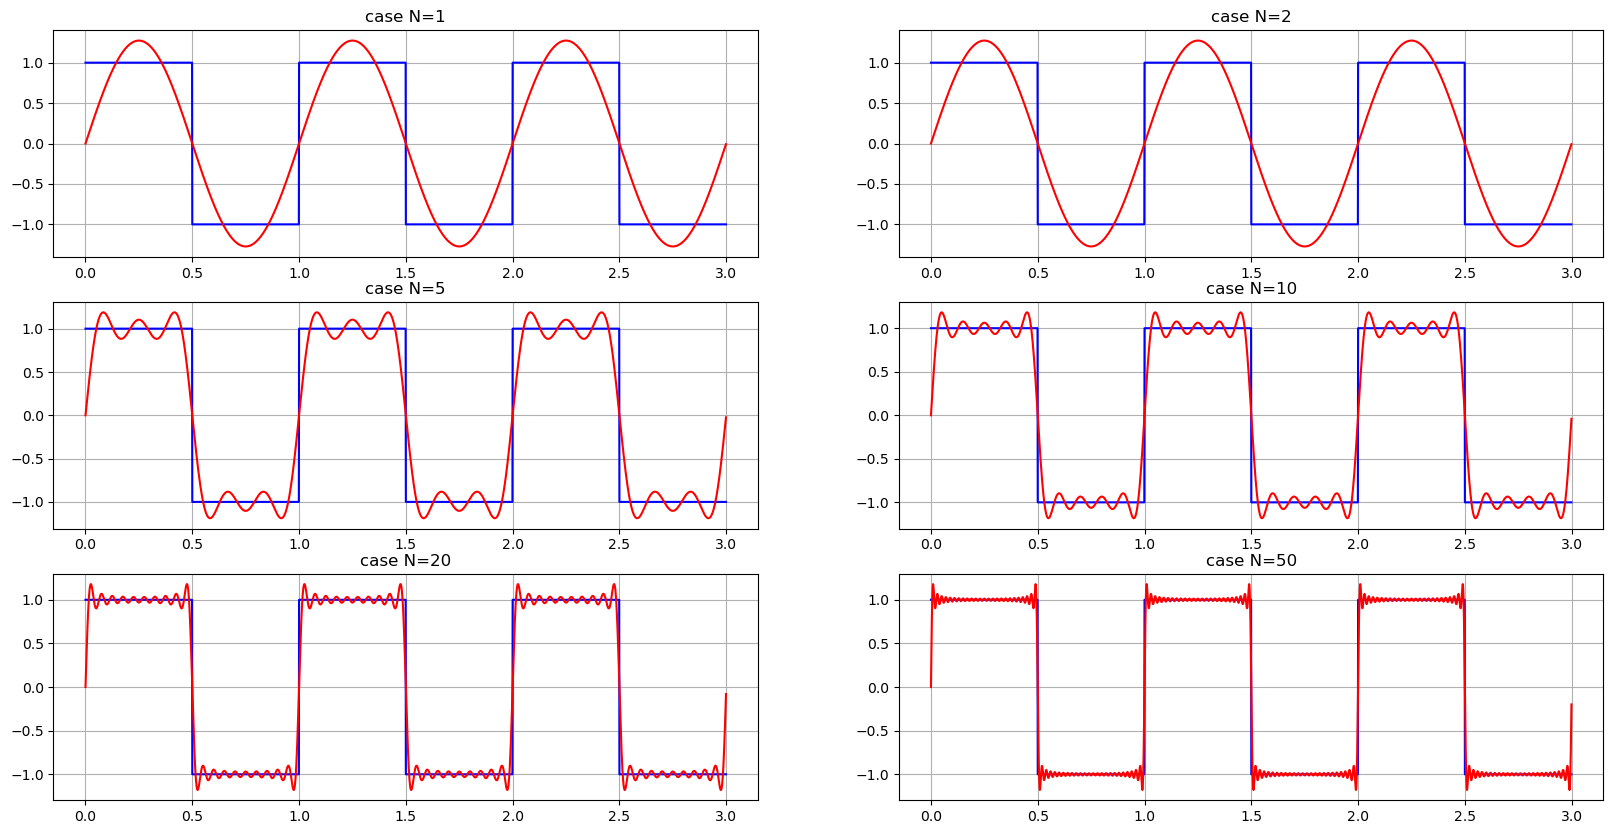

In [15]:
Ns=[1, 2, 5, 10 , 20 , 50]
columnas = 2
filas = int(np.ceil(len(Ns)/columnas))
fig,axs = plt.subplots(filas, columnas, figsize=(20, 10))
for m in range(1, len(Ns)+1):
    a = fourier_coef(f5, Ns[m-1], T)
    f5_reconstruct = serie_trunc(t,a,T)
    fila = (m-1) // columnas
    columna = (m-1) % columnas
    axs[fila, columna].set_title('case N=' + str(Ns[m-1]))
    axs[fila, columna].plot(t, f5(t), color='blue')
    axs[fila, columna].plot(t, np.real(f5_reconstruct), color='red')
    axs[fila, columna].grid()
plt.show()    

Veamos la onda triangular

In [16]:
f6 = lambda t: signal.sawtooth(2*np.pi*t/T, 0.5)

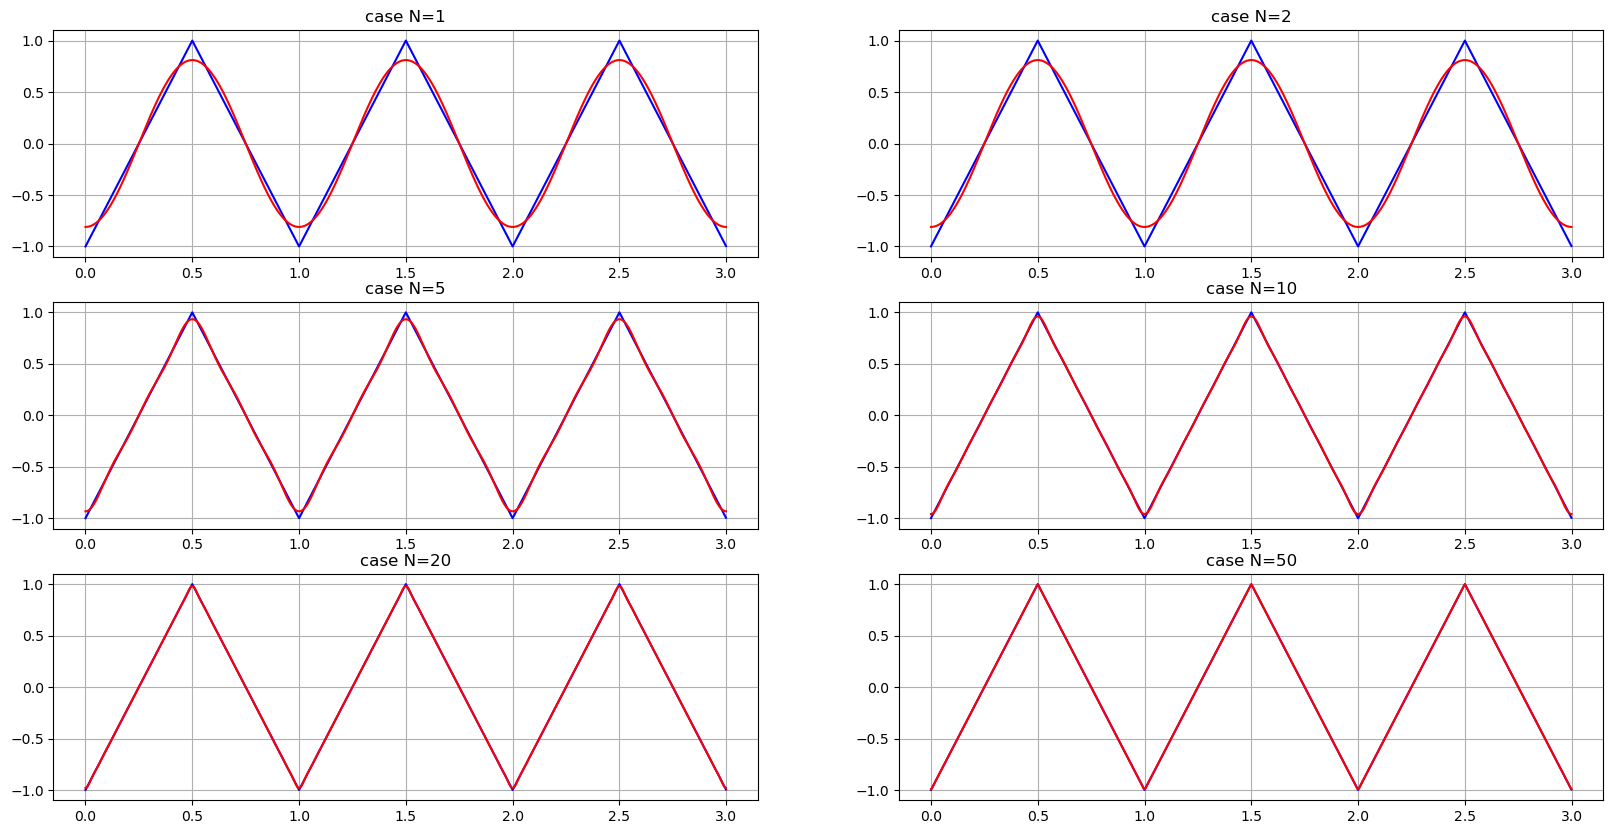

In [17]:
Ns=[1, 2, 5, 10 , 20 , 50]
columnas = 2
filas = int(np.ceil(len(Ns)/columnas))
fig,axs = plt.subplots(filas, columnas, figsize=(20, 10))
for m in range(1, len(Ns)+1):
    a = fourier_coef(f6, Ns[m-1], T)
    f6_reconstruct = serie_trunc(t,a,T)
    fila = (m-1) // columnas
    columna = (m-1) % columnas
    axs[fila, columna].set_title('case N=' + str(Ns[m-1]))
    axs[fila, columna].plot(t, f6(t), color='blue')
    axs[fila, columna].plot(t, np.real(f6_reconstruct), color='red')
    axs[fila, columna].grid()
plt.show()    

Veamos una onda en cuyo período tenemos una parábola invertida

In [18]:
f7 = lambda t: T**2/4 - (T/2-t%T)**2

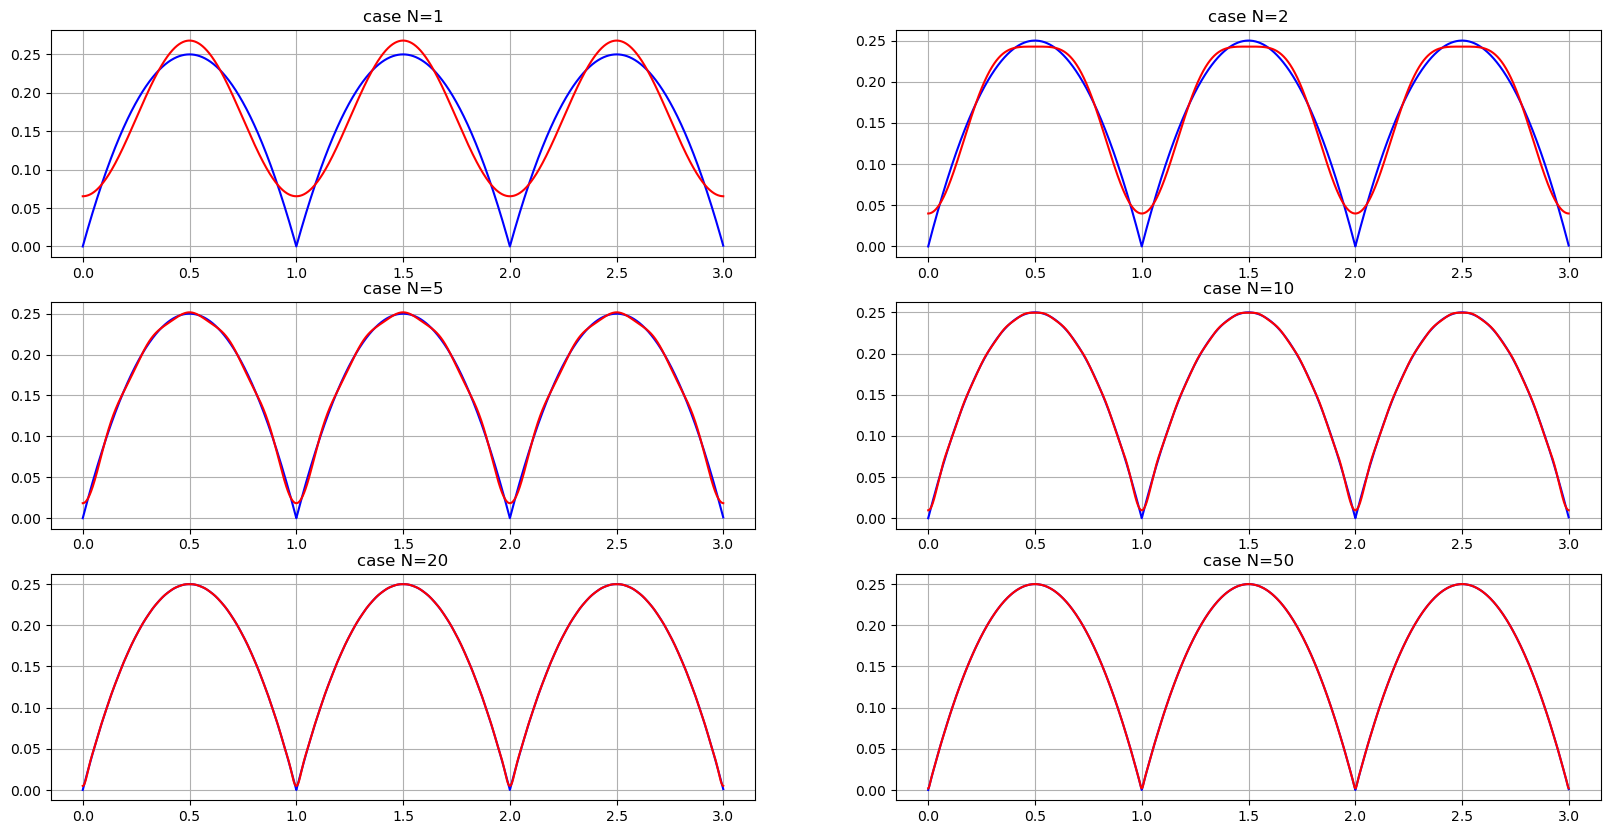

In [19]:
Ns=[1, 2, 5, 10 , 20 , 50]
columnas = 2
filas = int(np.ceil(len(Ns)/columnas))
fig,axs = plt.subplots(filas, columnas, figsize=(20, 10))
for m in range(1, len(Ns)+1):
    a = fourier_coef(f7, Ns[m-1], T)
    f7_reconstruct = serie_trunc(t,a,T)
    fila = (m-1) // columnas
    columna = (m-1) % columnas
    axs[fila, columna].set_title('case N=' + str(Ns[m-1]))
    axs[fila, columna].plot(t, f7(t), color='blue')
    axs[fila, columna].plot(t, np.real(f7_reconstruct), color='red')
    axs[fila, columna].grid()
plt.show() 

<b>Cuando veamos el tema de DFT veremos como calcular series de Fourier sin necesidad de hacer integrales y en forma mucho más eficiente!! Integrar es costoso y en general debe evitarse si es posible</b>

<b> Amplificadores y distorsión harmónica </b>

En la práctica muchas veces las señales del mundo real tienen una amplitud muy pequeña (ej: ECG, EEG) y para poder visualizar y trabajar con dichas señales es neceario amplificarlas. En otras ocasiones buscamos amplificarlas para que las mismas tengan mayor potencia (ej: equipo de audio). Si estamos midiendo una tensión $v_\mbox{in}(t)$ que representa la señal en la que estamos interesados, entonces generamos una señal $v_\mbox{out}(t)$ amplificada tal que:
$$v_\mbox{out}(t)=K v_{\mbox{in}}(t) $$

donde $K$ es la ganancia del amplificador y que naturalmente buscamos que sea $K\geq 1$. Vemos que la acción del amplificador se puede pensar como la de un sistema LTI sin memoria. O sea un sistema extremadamente simple. 

In [20]:
Image(url= "https://www.circuitbasics.com/wp-content/uploads/2020/07/amplifier_3.jpg", width=1000, height=1000)

Imagen extraída de https://www.circuitbasics.com/transistor-amplifiers

En la práctica, no obstante la característica del sistema no es tan sencilla. La característica lineal de amplificación tiene un límite. No vale para todas las amplitudes posibles de la señal
de entrada. Más allá de algunos valores, la característica del sistema deja de ser líneal. El intervalo de amplitudes de entrada en donde el rango permanece lineal se denomina <b>rango dinámico</b> 
del amplificador y es una característica sumamente importante del sistema.

In [21]:
K=4
rango_vin = 3.
saturacion = 1
vin = np.linspace(-rango_vin,rango_vin, round(fs * 2*rango_vin), endpoint=False)  
vout_ideal = K*vin
vout_real=K*np.clip(vin,-saturacion, saturacion) 

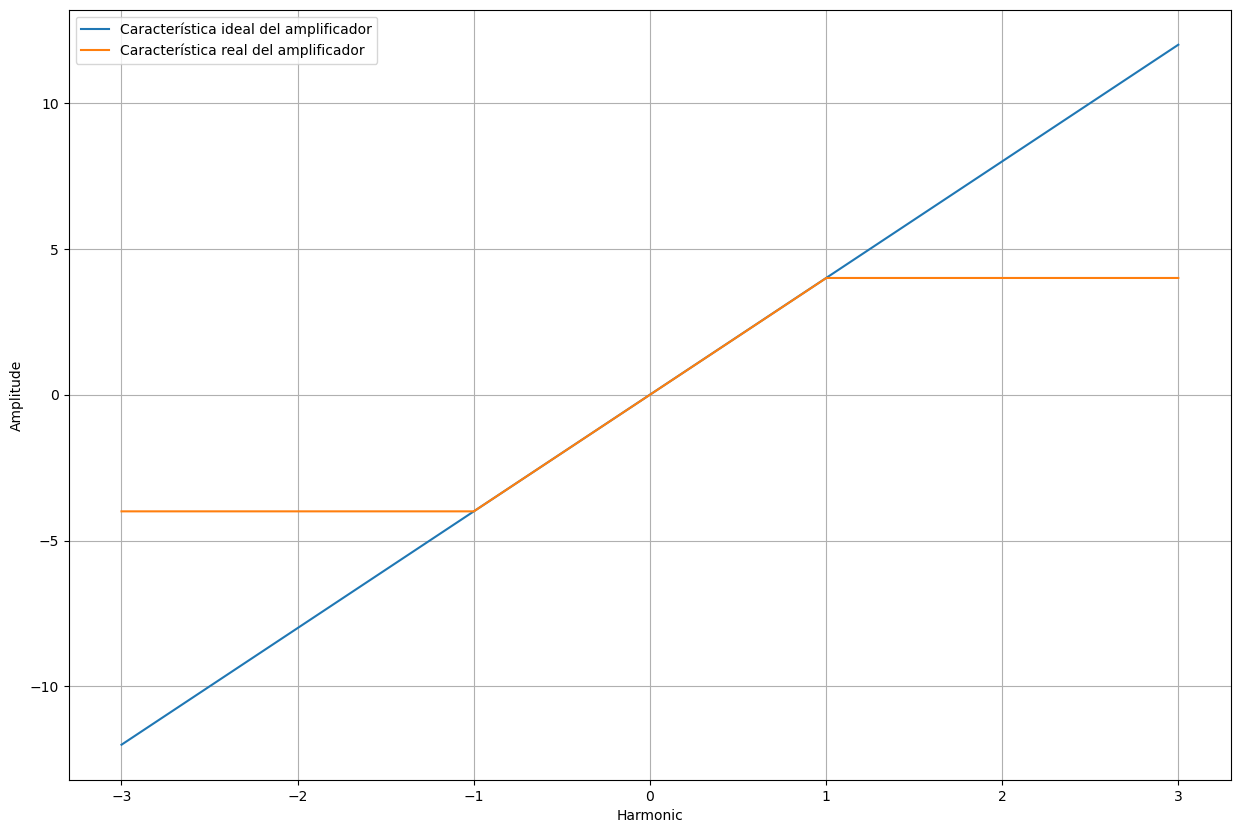

In [22]:
plt.figure(figsize=(15, 10))
plt.xlabel('Harmonic')
plt.ylabel('Amplitude')
plt.plot(vin, vout_ideal , label='Característica ideal del amplificador')   
plt.plot(vin, vout_real , label='Característica real del amplificador') 
plt.legend(loc='best')
plt.grid()
plt.show()

Consideremos ahora entradas sinusoidales a este sistema:
$$ x_\mbox{in}(t) = A \sin (2\pi f t+ \phi) $$
con distintos valores de amplitud $A$. 

In [23]:
# Sampling rate in Hz
fs = 1000
#Sampling period
Ts = 1/fs
#Datos de las sinusoides
A1 = 1
phi1 = 0
f1= 1
A2 = 3
phi2 = 0
f2= 1 
duration = 3

sin1_in = lambda t: A1 * np.sin((2 * np.pi) * t * f1 + phi1)
sin2_in = lambda t: A2 * np.sin((2 * np.pi) * t * f2 + phi2)


            
#sin1_out = lambda t: vout_real_amp(sin1_in(t),K, saturacion)
#sin2_out = lambda t: vout_real_amp(sin2_in(t),K, saturacion)

sin1_out = lambda t: K*np.clip(sin1_in(t),-saturacion, saturacion)
sin2_out = lambda t: K*np.clip(sin2_in(t),-saturacion, saturacion)

t = np.linspace(-duration, duration, round(fs * duration), endpoint=False)  
x1_in =sin1_in(t)
x2_in =sin2_in(t)

y1_out = sin1_out(t)
y2_out = sin2_out(t)


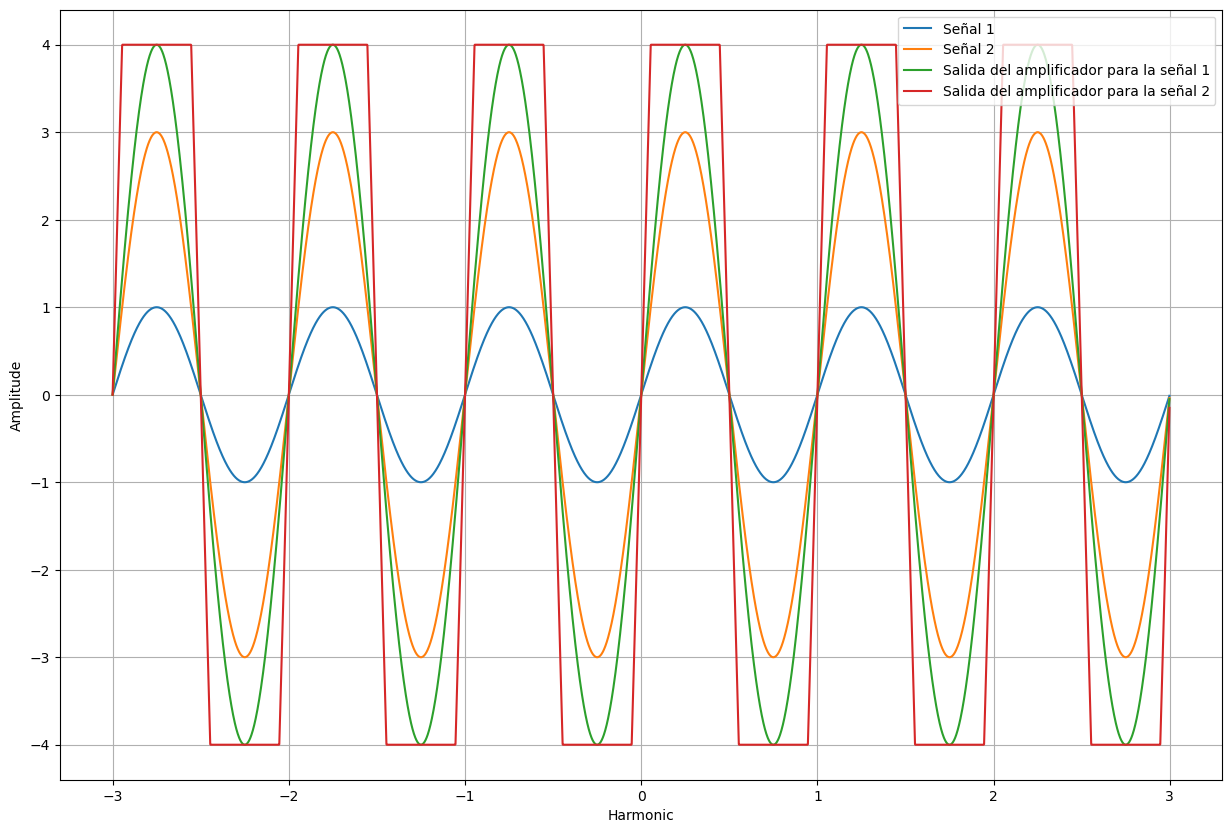

In [24]:
plt.figure(figsize=(15, 10))
plt.xlabel('Harmonic')
plt.ylabel('Amplitude')
plt.plot(t, x1_in , label='Señal 1')   
plt.plot(t, x2_in , label='Señal 2') 
plt.plot(t, y1_out , label='Salida del amplificador para la señal 1')   
plt.plot(t, y2_out , label='Salida del amplificador para la señal 2') 
plt.legend(loc='best')
plt.grid()
plt.show()

<b> Vemos que la señal con mayor amplitud a la salida del amplificador ya no es más un seno de la misma frecuencia que a la entrada. La señal se ha "distorsionado"!!</b>

Veamos que nos dice Fourier

In [27]:
order_fourier = 10
a1 = fourier_coef(sin1_out, order_fourier, 1/f1)
a2 = fourier_coef(sin2_out, order_fourier, 1/f2)

/tmp/ipykernel_608684/514666456.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_parte_imag, error_integral_parte_imag = integrate.quad(parte_imag, a, b)


<b> El warning tiene que ver con el método númerico para la integración. Puede necesario hacer una discretización más fina. En este caso en realidad no es necesario ya que la precisión 
que tenemos ya es buena. Por eso lo desechamos. Pero cuando Uds. tengan un warning siempre prestarle atención!!<b/>

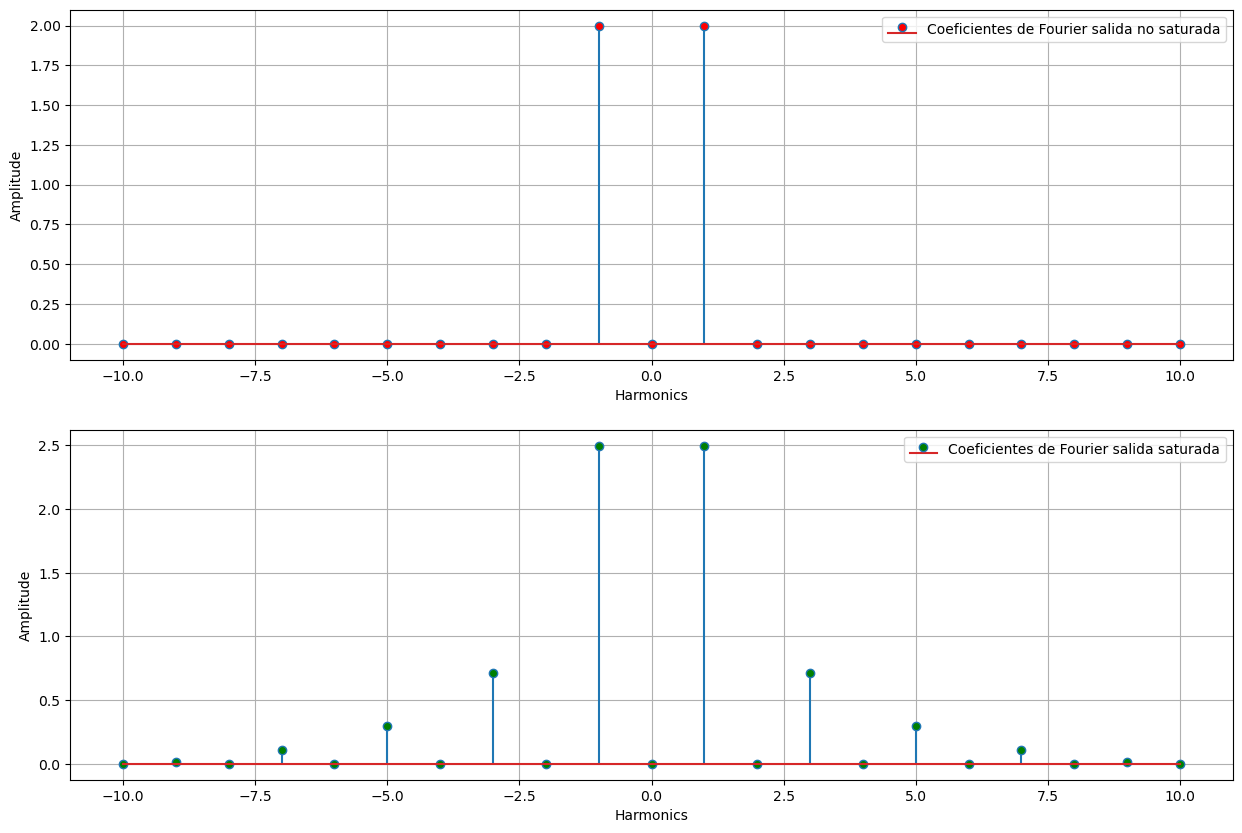

In [28]:
fig,axs = plt.subplots(2, figsize=(15, 10))
markerline1, stemlines1, baseline1 = axs[0].stem(np.arange(-order_fourier,order_fourier+1), np.abs(a1), label='Coeficientes de Fourier salida no saturada')  
markerline1.set_markerfacecolor('red')
markerline2, stemlines2, baseline2 = axs[1].stem(np.arange(-order_fourier,order_fourier+1), np.abs(a2), label='Coeficientes de Fourier salida saturada')  
markerline2.set_markerfacecolor('green')
for ax in axs:
    ax.set(xlabel='Harmonics', ylabel='Amplitude')
    ax.grid()
    ax.legend(loc='upper right')

<b> Notar como la señal de salida saturada presenta varios armónicos. O sea el sistema no lineal generó armónicos que no estaban presentes en la entrada. Cuando necesita trabajar con 
sistemas de alta calidad (ej: audio) estos fenómenos deben evitarse ya que pueden alterar sustancialmente la calidad de las señales de salida</b>